# Detecting Maclicious URLs using Machine Learning<br>
The malicious urls can be detected using the lexical features along with tokenization of the url strings. I aim to build a basic binary classifier which would help classify the URLs as malicious or benign.

Steps followed in building the machine learning classifier<br>
1. Data Preprocessing / Feature Engineering
2. Data Visualization
3. Building Machine Learning Models using Lexical Features.
4. Building Machine Learning Models using Lexical Features and Tokenization. (Will Update this part)

Importing The Dependencies

In [1]:

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import os
print(os.listdir("../input"))


['urldata.csv']


In [2]:
urldata = pd.read_csv("../input/urldata.csv")

In [3]:
urldata.head()

,Unnamed: 0,url,label,result
0,0,https://www.google.com,benign,0
1,1,https://www.youtube.com,benign,0
2,2,https://www.facebook.com,benign,0
3,3,https://www.baidu.com,benign,0
4,4,https://www.wikipedia.org,benign,0


In [4]:
#Removing the unnamed columns as it is not necesary.
urldata = urldata.drop('Unnamed: 0',axis=1)

In [5]:
urldata.head()

,url,label,result
0,https://www.google.com,benign,0
1,https://www.youtube.com,benign,0
2,https://www.facebook.com,benign,0
3,https://www.baidu.com,benign,0
4,https://www.wikipedia.org,benign,0


In [6]:
urldata.shape

(450176, 3)

In [7]:
urldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450176 entries, 0 to 450175
Data columns (total 3 columns):
url       450176 non-null object
label     450176 non-null object
result    450176 non-null int64
dtypes: int64(1), object(2)
memory usage: 10.3+ MB


Checking Missing Values

In [8]:
urldata.isnull().sum()

url       0
label     0
result    0
dtype: int64

No missing values in any column.

# 1. DATA PREPROCESSING

The following features will be extracted from the URL for classification. <br>
<ol>
    <li>Length Features
    <ul>
        <li>Length Of Url</li>
        <li>Length of Hostname</li>
        <li>Length Of Path</li>
        <li>Length Of First Directory</li>
        <li>Length Of Top Level Domain</li>
    </ul>
    </li>
    <br>
   <li>Count Features
    <ul>
    <li>Count Of  '-'</li>
    <li>Count Of '@'</li>
    <li>Count Of '?'</li>
    <li>Count Of '%'</li>
    <li>Count Of '.'</li>
    <li>Count Of '='</li>
    <li>Count Of 'http'</li>
    <li>Count Of 'www'</li>
    <li>Count Of Digits</li>
    <li>Count Of Letters</li>
    <li>Count Of Number Of Directories</li>
    </ul>
    </li>
    <br>
    <li>Binary Features
    <ul>
        <li>Use of IP or not</li>
        <li>Use of Shortening URL or not</li>
    </ul>
    </li>
    
</ol>

Apart from the lexical features, we will use TFID - Term Frequency Inverse Document as well.

### 1.1 Length Features

In [9]:
#Importing dependencies
from urllib.parse import urlparse
import os.path

In [10]:
#Length of URL
urldata['url_length'] = urldata['url'].apply(lambda i: len(str(i)))

In [11]:
#Hostname Length
urldata['hostname_length'] = urldata['url'].apply(lambda i: len(urlparse(i).netloc))

In [12]:
#Path Length
urldata['path_length'] = urldata['url'].apply(lambda i: len(urlparse(i).path))

In [13]:
#First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

urldata['fd_length'] = urldata['url'].apply(lambda i: fd_length(i))

In [14]:
urldata.head()

,url,label,result,url_length,hostname_length,path_length,fd_length
0,https://www.google.com,benign,0,22,14,0,0
1,https://www.youtube.com,benign,0,23,15,0,0
2,https://www.facebook.com,benign,0,24,16,0,0
3,https://www.baidu.com,benign,0,21,13,0,0
4,https://www.wikipedia.org,benign,0,25,17,0,0


Dataset after extracting length features

### 1.2 Count Features

In [15]:
urldata['count-'] = urldata['url'].apply(lambda i: i.count('-'))

In [16]:
urldata['count@'] = urldata['url'].apply(lambda i: i.count('@'))

In [17]:
urldata['count?'] = urldata['url'].apply(lambda i: i.count('?'))

In [18]:
urldata['count%'] = urldata['url'].apply(lambda i: i.count('%'))

In [19]:
urldata['count.'] = urldata['url'].apply(lambda i: i.count('.'))

In [20]:
urldata['count='] = urldata['url'].apply(lambda i: i.count('='))

In [21]:
urldata['count-http'] = urldata['url'].apply(lambda i : i.count('http'))

In [22]:
urldata['count-https'] = urldata['url'].apply(lambda i : i.count('https'))

In [23]:
urldata['count-www'] = urldata['url'].apply(lambda i: i.count('www'))

In [24]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits
urldata['count-digits']= urldata['url'].apply(lambda i: digit_count(i))

In [25]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters
urldata['count-letters']= urldata['url'].apply(lambda i: letter_count(i))

In [26]:
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')
urldata['count_dir'] = urldata['url'].apply(lambda i: no_of_dir(i))

Data after extracting Count Features

In [27]:
urldata.head()

,url,label,result,url_length,hostname_length,path_length,fd_length,count-,count@,count?,count%,count.,count=,count-http,count-https,count-www,count-digits,count-letters,count_dir
0,https://www.google.com,benign,0,22,14,0,0,0,0,0,0,2,0,1,1,1,0,17,0
1,https://www.youtube.com,benign,0,23,15,0,0,0,0,0,0,2,0,1,1,1,0,18,0
2,https://www.facebook.com,benign,0,24,16,0,0,0,0,0,0,2,0,1,1,1,0,19,0
3,https://www.baidu.com,benign,0,21,13,0,0,0,0,0,0,2,0,1,1,1,0,16,0
4,https://www.wikipedia.org,benign,0,25,17,0,0,0,0,0,0,2,0,1,1,1,0,20,0


### 1.3 Binary Features

In [28]:
import re

In [29]:
#Use of IP or not in domain
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return -1
    else:
        # print 'No matching pattern found'
        return 1
urldata['use_of_ip'] = urldata['url'].apply(lambda i: having_ip_address(i))

In [30]:
def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return -1
    else:
        return 1
urldata['short_url'] = urldata['url'].apply(lambda i: shortening_service(i))

Data after extracting Binary Features

In [31]:
urldata.head()

,url,label,result,url_length,hostname_length,path_length,fd_length,count-,count@,count?,count%,count.,count=,count-http,count-https,count-www,count-digits,count-letters,count_dir,use_of_ip,short_url
0,https://www.google.com,benign,0,22,14,0,0,0,0,0,0,2,0,1,1,1,0,17,0,1,1
1,https://www.youtube.com,benign,0,23,15,0,0,0,0,0,0,2,0,1,1,1,0,18,0,1,1
2,https://www.facebook.com,benign,0,24,16,0,0,0,0,0,0,2,0,1,1,1,0,19,0,1,1
3,https://www.baidu.com,benign,0,21,13,0,0,0,0,0,0,2,0,1,1,1,0,16,0,1,1
4,https://www.wikipedia.org,benign,0,25,17,0,0,0,0,0,0,2,0,1,1,1,0,20,0,1,1


# 2. Data Visualization

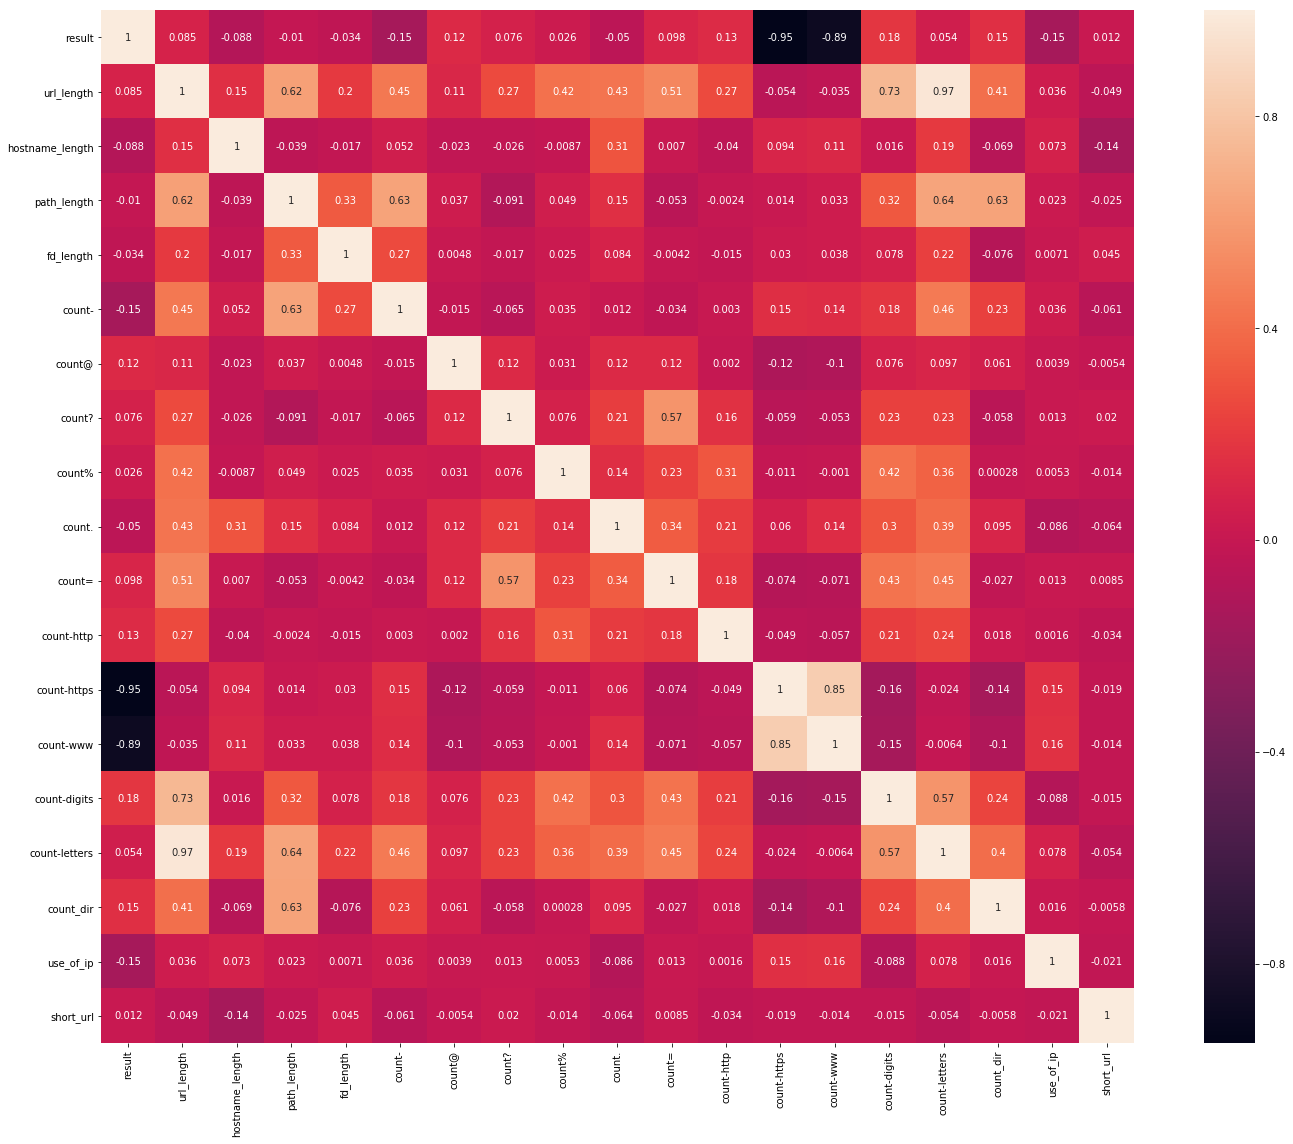

In [32]:
#Heatmap
corrmat = urldata.corr()
f, ax = plt.subplots(figsize=(25,19))
sns.heatmap(corrmat, square=True, annot = True, annot_kws={'size':10})

Text(0, 0.5, 'Number Of URLs')

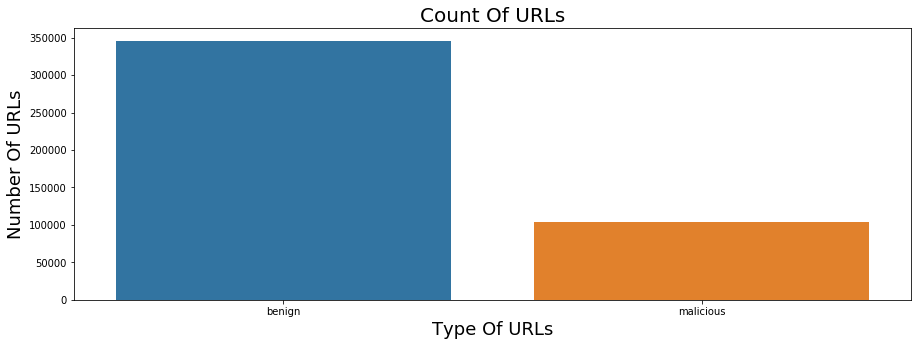

In [33]:
plt.figure(figsize=(15,5))
sns.countplot(x='label',data=urldata)
plt.title("Count Of URLs",fontsize=20)
plt.xlabel("Type Of URLs",fontsize=18)
plt.ylabel("Number Of URLs",fontsize=18)

In [34]:
print("Percent Of Malicious URLs:{:.2f} %".format(len(urldata[urldata['label']=='malicious'])/len(urldata['label'])*100))
print("Percent Of Benign URLs:{:.2f} %".format(len(urldata[urldata['label']=='benign'])/len(urldata['label'])*100))

Percent Of Malicious URLs:23.20 %
Percent Of Benign URLs:76.80 %


The data shows a class imbalance to some extent.

(0, 1000)

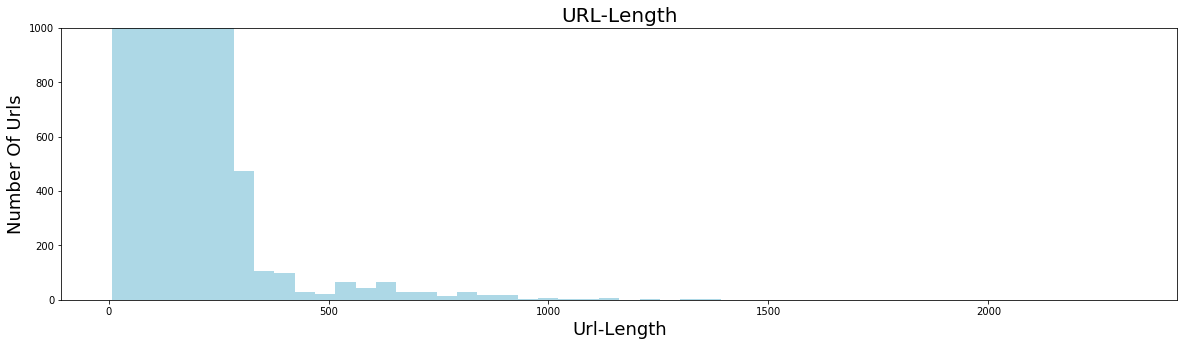

In [35]:
plt.figure(figsize=(20,5))
plt.hist(urldata['url_length'],bins=50,color='LightBlue')
plt.title("URL-Length",fontsize=20)
plt.xlabel("Url-Length",fontsize=18)
plt.ylabel("Number Of Urls",fontsize=18)
plt.ylim(0,1000)


(0, 1000)

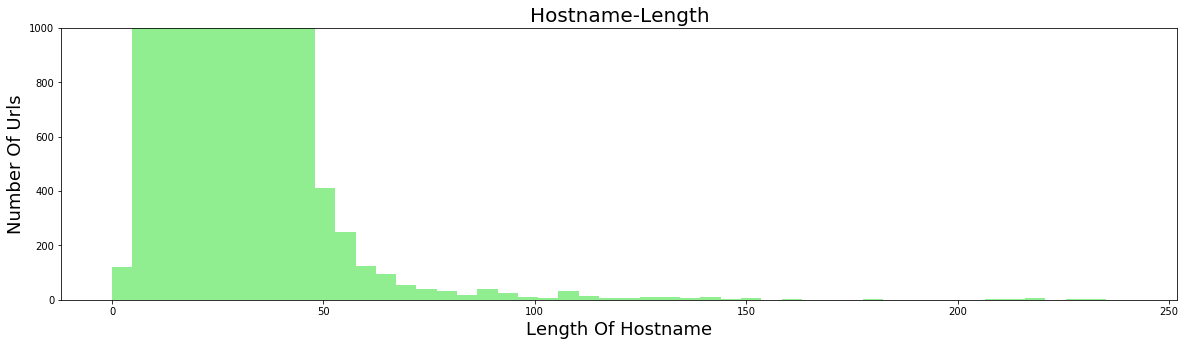

In [36]:
plt.figure(figsize=(20,5))
plt.hist(urldata['hostname_length'],bins=50,color='Lightgreen')
plt.title("Hostname-Length",fontsize=20)
plt.xlabel("Length Of Hostname",fontsize=18)
plt.ylabel("Number Of Urls",fontsize=18)
plt.ylim(0,1000)

Text(0, 0.5, 'Number Of URLs')

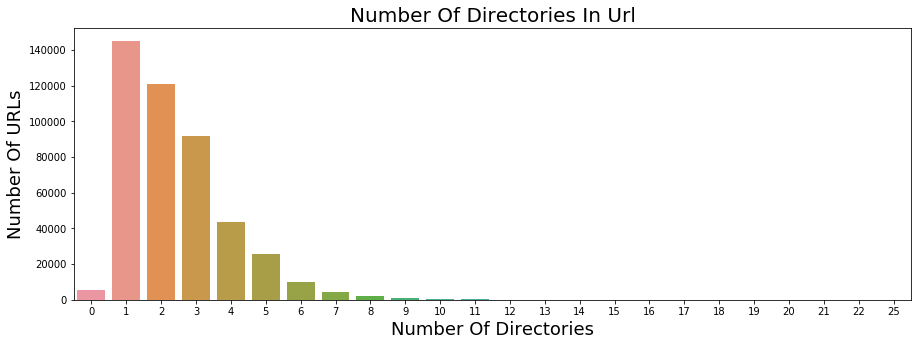

In [37]:
plt.figure(figsize=(15,5))
plt.title("Number Of Directories In Url",fontsize=20)
sns.countplot(x='count_dir',data=urldata)
plt.xlabel("Number Of Directories",fontsize=18)
plt.ylabel("Number Of URLs",fontsize=18)

Text(0, 0.5, 'Number Of URLs')

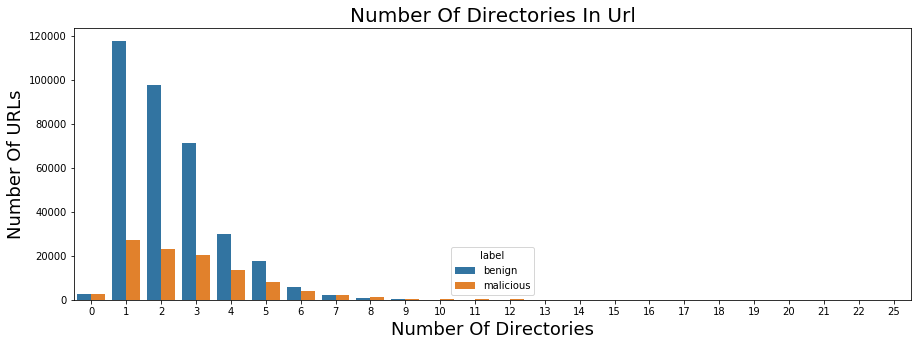

In [38]:
plt.figure(figsize=(15,5))
plt.title("Number Of Directories In Url",fontsize=20)
sns.countplot(x='count_dir',data=urldata,hue='label')
plt.xlabel("Number Of Directories",fontsize=18)
plt.ylabel("Number Of URLs",fontsize=18)

Text(0, 0.5, 'Number of URLs')

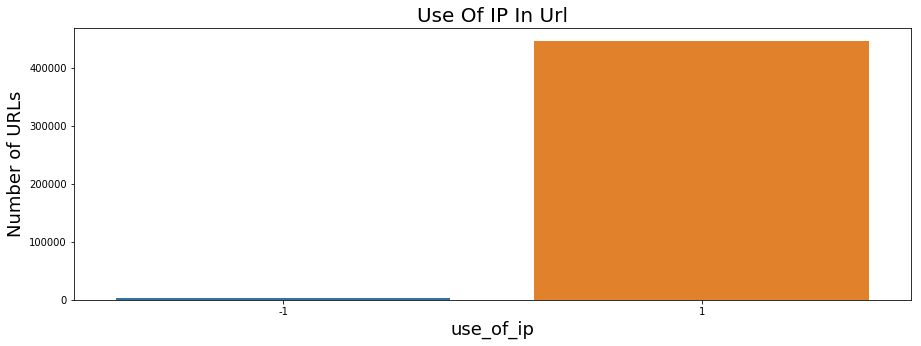

In [39]:
plt.figure(figsize=(15,5))
plt.title("Use Of IP In Url",fontsize=20)
plt.xlabel("Use Of IP",fontsize=18)

sns.countplot(urldata['use_of_ip'])
plt.ylabel("Number of URLs",fontsize=18)

Text(0, 0.5, 'Number of URLs')

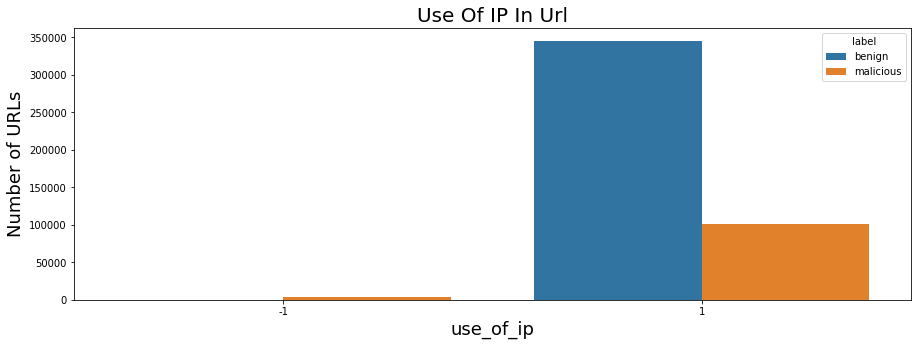

In [40]:
plt.figure(figsize=(15,5))
plt.title("Use Of IP In Url",fontsize=20)
plt.xlabel("Use Of IP",fontsize=18)
plt.ylabel("Number of URLs",fontsize=18)
sns.countplot(urldata['use_of_ip'],hue='label',data=urldata)
plt.ylabel("Number of URLs",fontsize=18)

Text(0, 0.5, 'Number of URLs')

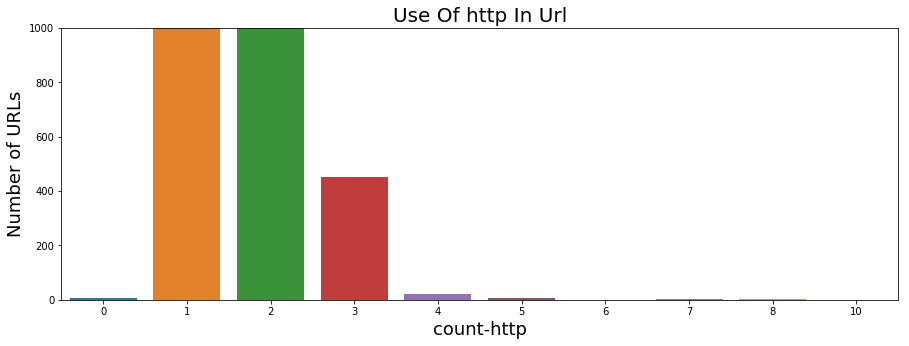

In [41]:
plt.figure(figsize=(15,5))
plt.title("Use Of http In Url",fontsize=20)
plt.xlabel("Use Of IP",fontsize=18)
plt.ylim((0,1000))
sns.countplot(urldata['count-http'])
plt.ylabel("Number of URLs",fontsize=18)

Text(0, 0.5, 'Number of URLs')

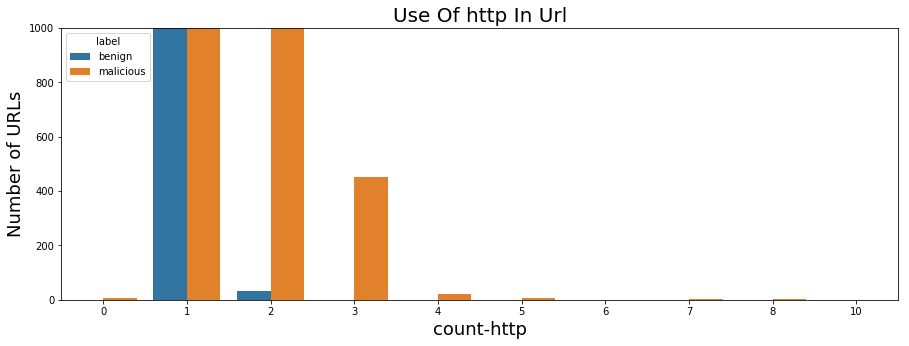

In [42]:
plt.figure(figsize=(15,5))
plt.title("Use Of http In Url",fontsize=20)
plt.xlabel("Count Of http",fontsize=18)
plt.ylabel("Number of URLs",fontsize=18)
plt.ylim((0,1000))
sns.countplot(urldata['count-http'],hue='label',data=urldata)
plt.ylabel("Number of URLs",fontsize=18)

Text(0, 0.5, 'Number of URLs')

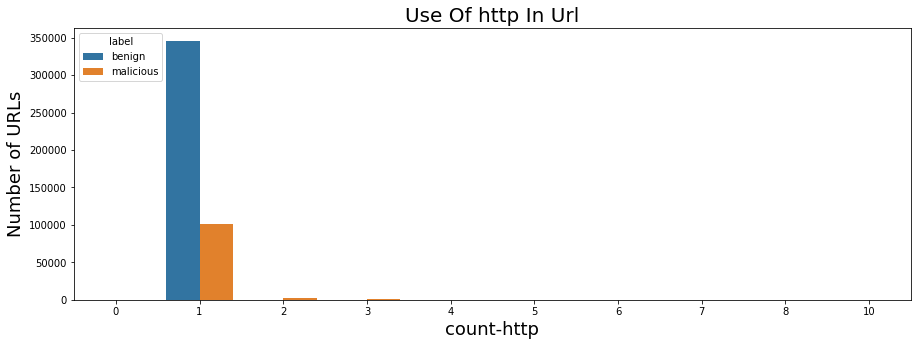

In [43]:
plt.figure(figsize=(15,5))
plt.title("Use Of http In Url",fontsize=20)
plt.xlabel("Count Of http",fontsize=18)

sns.countplot(urldata['count-http'],hue='label',data=urldata)

plt.ylabel("Number of URLs",fontsize=18)

Text(0, 0.5, 'Number Of URLs')

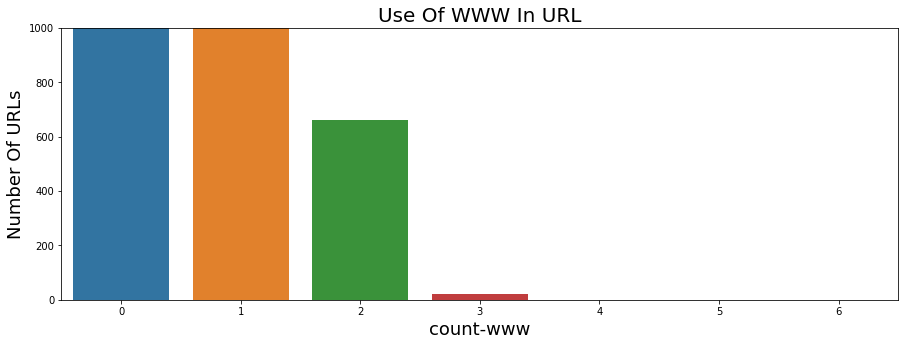

In [44]:
plt.figure(figsize=(15,5))
plt.title("Use Of WWW In URL",fontsize=20)
plt.xlabel("Count Of WWW",fontsize=18)
sns.countplot(urldata['count-www'])
plt.ylim(0,1000)
plt.ylabel("Number Of URLs",fontsize=18)

Text(0, 0.5, 'Number Of URLs')

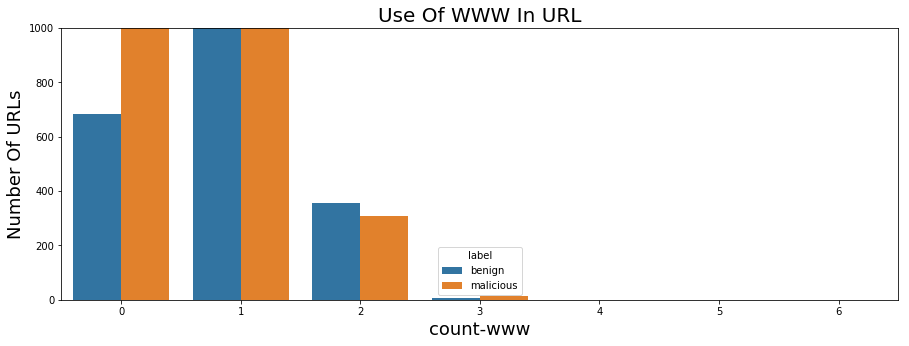

In [45]:
plt.figure(figsize=(15,5))
plt.title("Use Of WWW In URL",fontsize=20)
plt.xlabel("Count Of WWW",fontsize=18)

sns.countplot(urldata['count-www'],hue='label',data=urldata)
plt.ylim(0,1000)
plt.ylabel("Number Of URLs",fontsize=18)

# 3. Building Models Using Lexical Features Only


<br>1. Logistic Regression
<br>2. XGBoost Classifier
<br>3. Random Forest

In [46]:
#from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score




In [47]:
#Independent Variables
x = urldata[['hostname_length',
       'path_length', 'fd_length', 'count-', 'count@', 'count?',
       'count%', 'count.', 'count=', 'count-http','count-https', 'count-www', 'count-digits',
       'count-letters', 'count_dir', 'use_of_ip']]

#Dependent Variable
y = urldata['result']

## 3.1 Train test split

In [48]:
#Oversampling using SMOTE
from imblearn.over_sampling import SMOTE

x_sample, y_sample = SMOTE().fit_sample(x, y.values.ravel())

x_sample = pd.DataFrame(x_sample)
y_sample = pd.DataFrame(y_sample)

# checking the sizes of the sample data
print("Size of x-sample :", x_sample.shape)
print("Size of y-sample :", y_sample.shape)

Using TensorFlow backend.


Size of x-sample : (691476, 16)
Size of y-sample : (691476, 1)


In [49]:
#Train test split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_sample, y_sample, test_size = 0.2)
print("Shape of x_train: ", x_train.shape)
print("Shape of x_valid: ", x_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_valid: ", y_test.shape)

Shape of x_train:  (553180, 16)
Shape of x_valid:  (138296, 16)
Shape of y_train:  (553180, 1)
Shape of y_valid:  (138296, 1)


In [50]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import ModelCheckpoint
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization ,Activation
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

In [51]:
x_train.shape

(553180, 16)

In [52]:
model = Sequential()
model.add(Dense(32, activation = 'relu', input_shape = (16, )))

model.add(Dense(16, activation='relu'))

model.add(Dense(8, activation='relu')) 

model.add(Dense(1, activation='sigmoid')) 
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 1,217
Trainable params: 1,217
Non-trainable params: 0
_________________________________________________________________


In [53]:
opt = keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer= opt ,loss='binary_crossentropy',metrics=['acc'])

In [54]:
checkpointer = ModelCheckpoint('url.h5', monitor='val_acc', mode='max', verbose=2, save_best_only=True)
history=model.fit(x_train, y_train, batch_size=256, epochs=5, validation_data=(x_test, y_test), callbacks=[checkpointer])

Instructions for updating:
Use tf.cast instead.
Train on 553180 samples, validate on 138296 samples
Epoch 1/5
553180/553180 [==============================] - 5s 10us/step - loss: 0.3936 - acc: 0.8295 - val_loss: 0.1154 - val_acc: 0.9763

Epoch 00001: val_acc improved from -inf to 0.97632, saving model to url.h5
Epoch 2/5
553180/553180 [==============================] - 5s 9us/step - loss: 0.0575 - acc: 0.9885 - val_loss: 0.0336 - val_acc: 0.9931

Epoch 00002: val_acc improved from 0.97632 to 0.99311, saving model to url.h5
Epoch 3/5
553180/553180 [==============================] - 5s 8us/step - loss: 0.0251 - acc: 0.9953 - val_loss: 0.0221 - val_acc: 0.9955

Epoch 00003: val_acc improved from 0.99311 to 0.99548, saving model to url.h5
Epoch 4/5
553180/553180 [==============================] - 5s 8us/step - loss: 0.0191 - acc: 0.9962 - val_loss: 0.0194 - val_acc: 0.9959

Epoch 00004: val_acc improved from 0.99548 to 0.99586, saving model to url.h5
Epoch 5/5
553180/553180 [=============

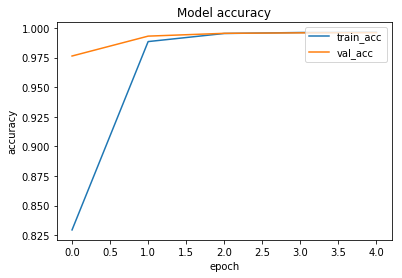

In [55]:
# plot the training artifacts
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc','val_acc'], loc = 'upper right')
plt.show()

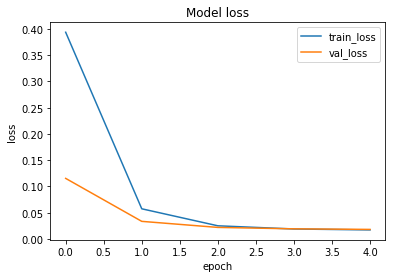

In [56]:
# plot the training artifacts

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

In [59]:
# predicting on test data.
pred_test = model.predict(x_test)
for i in range (len(pred_test)):
    if (pred_test[i] < 0.5):
        pred_test[i] = 0
    else:
        pred_test[i] = 1
pred_test = pred_test.astype(int)

In [62]:
def view_result(array):
    array = np.array(array)
    for i in range(len(array)):
        if array[i] == 0:
            print("Non Mallicious")
        else:
            print("Mallicious")

In [63]:
view_result(pred_test[:10])

Non Mallicious
Mallicious
Mallicious
Non Mallicious
Non Mallicious
Non Mallicious
Mallicious
Non Mallicious
Mallicious
Mallicious


In [64]:
view_result(y_test[:10])

Non Mallicious
Mallicious
Mallicious
Non Mallicious
Non Mallicious
Non Mallicious
Mallicious
Non Mallicious
Mallicious
Mallicious
